# Chapter 3

In the chapter 3 of "Web Scraping with Python" you were able to learn more about the following subjects:
* Tracking internal links of website
  * According to pattern
  * All internal links
* Website mapping
* Collecting data
* Tracking through internet

The following cells aim to practice the contents listed above. For any sugestions, contact *gabriel.vasconcelos@usp.br*

Use the website https://scraping-cap3.netlify.app/ to answer this notebook.

In [185]:
# Import BeautifulSoup and other libraries you find useful

import networkx as nx
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib.parse import urlparse
from urllib.error import HTTPError
from urllib.error import URLError
import re, random

In [109]:
# Get the website https://scraping-cap3.netlify.app/ and pass it to a BeautifulSoup object 
# with proper error handling

def get_bs_site(url):
    try:
        html = urlopen(url)
    except HTTPError as e:
        print(f"Erro HTTP: {e}")
        return None
    except URLError as e:
        print(f"Nao conseguiu acessar o site: {e}")
        return None
    
    bs = BeautifulSoup(html, 'html.parser')

    return bs

bs = get_bs_site("https://scraping-cap3.netlify.app/")

bs.h1

<h1>Rock Encyclopedia</h1>

### a.
Get all internal links from the domain.

In [219]:
def getInternalUrls(url):
    bs = get_bs_site(url)

    if not bs:
        return None

    domain = urlparse(url).netloc
    urls = bs.findAll("a", href=re.compile(f"(^\.*\/)|(^http(s?):\/\/{domain})"))
    urls = set([url.attrs['href'] for url in urls])

    return urls

getInternalUrls("https://scraping-cap3.netlify.app/")

{'./baixistas.html',
 './bandas.html',
 './bateristas.html',
 './guitarristas.html',
 './index.html',
 './tecladistas.html',
 './vocalistas.html'}

In [220]:
# Code below
# Tip: use BFS algorithm to do a full mapping of the domain

def makeUrl(link):
    url = "https://scraping-cap3.netlify.app/" 

    if link.startswith("/"):
        url += link[1:]
    elif link.startswith("./"):
        url += link[2:]
    elif link.startswith("../"):
        url += link[3:]
    else:
        return link

    return url

def bfs(url):
    links = set()
    queue = []
    visitado = set()

    queue.append(url)
    visitado.add(url)

    while len(queue) > 0:
        now = makeUrl(queue.pop(0))
        links.add(now)
        urls = getInternalUrls(now) 

        for url in urls:
            formatedUrl = makeUrl(url)
            if formatedUrl not in visitado:
                queue.append(formatedUrl)
                visitado.add(formatedUrl)

    return links

links_all = bfs("https://scraping-cap3.netlify.app/index.html")
links_all

{'https://scraping-cap3.netlify.app/baixistas.html',
 'https://scraping-cap3.netlify.app/baixistas/Dee_Dee_Ramone.html',
 'https://scraping-cap3.netlify.app/baixistas/Geezer_Butler.html',
 'https://scraping-cap3.netlify.app/baixistas/John_Paul_Jones.html',
 'https://scraping-cap3.netlify.app/baixistas/Krist_Novoselic.html',
 'https://scraping-cap3.netlify.app/baixistas/Paul_McCartney.html',
 'https://scraping-cap3.netlify.app/baixistas/Roger_Glover.html',
 'https://scraping-cap3.netlify.app/baixistas/Simon_Gallup.html',
 'https://scraping-cap3.netlify.app/bandas.html',
 'https://scraping-cap3.netlify.app/bandas/Black_Sabbath.html',
 'https://scraping-cap3.netlify.app/bandas/Deep_Purple.html',
 'https://scraping-cap3.netlify.app/bandas/Led_Zeppelin.html',
 'https://scraping-cap3.netlify.app/bandas/Nirvana.html',
 'https://scraping-cap3.netlify.app/bandas/Ramones.html',
 'https://scraping-cap3.netlify.app/bandas/The_Beatles.html',
 'https://scraping-cap3.netlify.app/bandas/The_Cure.html'

### b.
Get all external links from the domain.

In [199]:
# Code below
def getExternalUrls(url):
    bs = get_bs_site(url)

    if not bs:
        return None

    links = bs.findAll("a", href=re.compile(r"(^http(s?):\/\/)"))
    links = set([link.attrs["href"] for link in links if "href" in link.attrs])
    links = links.difference(getInternalUrls(url))
    
    return links

ext_links = getExternalUrls("https://scraping-cap3.netlify.app/")

ext_links 

{'https://github.com/kibonusp',
 'https://www.linkedin.com/in/gabrielfreitas-xv/'}

### c.
Get the title of each page in the website, its url and the first paragraph.

In [188]:
# Code below

def getPageInfo(url):
    page_info = {}
    page_info["url"] = url 
    page_bs = get_bs_site(page_info["url"])
    title = None
    if page_bs.title:
        title = page_bs.title.get_text()
    parag = None
    if page_bs.p:
        parag = page_bs.p.get_text()

    page_info["title"] = title
    page_info["paragraph"] = parag

    return page_info

data = []
for url in links_all:
    data.append(getPageInfo(url))

data

[{'url': 'https://scraping-cap3.netlify.app/guitarristas/Johnny_Ramone.html',
  'title': 'Johnny Ramone',
  'paragraph': 'John William Cummings (Long Island, Nova Iorque, 8 de outubro de 1948 — Los Angeles, Califórnia, 15 de setembro de 2004), mais conhecido como Johnny Ramone, foi um dos mais influentes guitarristas de punk rock da história, tendo integrado a banda Ramones. Assim como o vocalista Joey Ramone, ele permaneceu membro do quarteto punk até o fim.'},
 {'url': 'https://scraping-cap3.netlify.app/bandas/Deep_Purple.html',
  'title': 'Deep Purple',
  'paragraph': 'Deep Purple é uma banda britânica de rock formada em Londres, em 1968.[1] Juntamente com as bandas Black Sabbath e Led Zeppelin, o Deep Purple é considerado um dos pioneiros do heavy metal e do hard rock moderno, embora alguns de seus integrantes tenham tentado não se categorizar como apenas um destes gêneros.[2][3] A banda também incorporou elementos do barroco, da psicodelia, do blues e do rock progressivo ao seu so

### d.
Create an adjacency list of the domain (directed graph).

In [189]:
# Code below

adjacencyList = {}

for link in links_all:
    adjacencyList[link] = [makeUrl(url) for url in getInternalUrls(link)]

adjacencyList

{'https://scraping-cap3.netlify.app/guitarristas/Johnny_Ramone.html': ['https://scraping-cap3.netlify.app/guitarristas.html',
  'https://scraping-cap3.netlify.app/bateristas.html',
  'https://scraping-cap3.netlify.app/vocalistas.html',
  'https://scraping-cap3.netlify.app/index.html',
  'https://scraping-cap3.netlify.app/bandas/Ramones.html',
  'https://scraping-cap3.netlify.app/baixistas.html',
  'https://scraping-cap3.netlify.app/bandas.html',
  'https://scraping-cap3.netlify.app/tecladistas.html'],
 'https://scraping-cap3.netlify.app/bandas/Deep_Purple.html': ['https://scraping-cap3.netlify.app/bateristas/Ian_Paice.html',
  'https://scraping-cap3.netlify.app/guitarristas.html',
  'https://scraping-cap3.netlify.app/vocalistas/Ian_Gillan.html',
  'https://scraping-cap3.netlify.app/bateristas.html',
  'https://scraping-cap3.netlify.app/guitarristas/Ritchie_Blackmore.html',
  'https://scraping-cap3.netlify.app/baixistas/Roger_Glover.html',
  'https://scraping-cap3.netlify.app/vocalistas

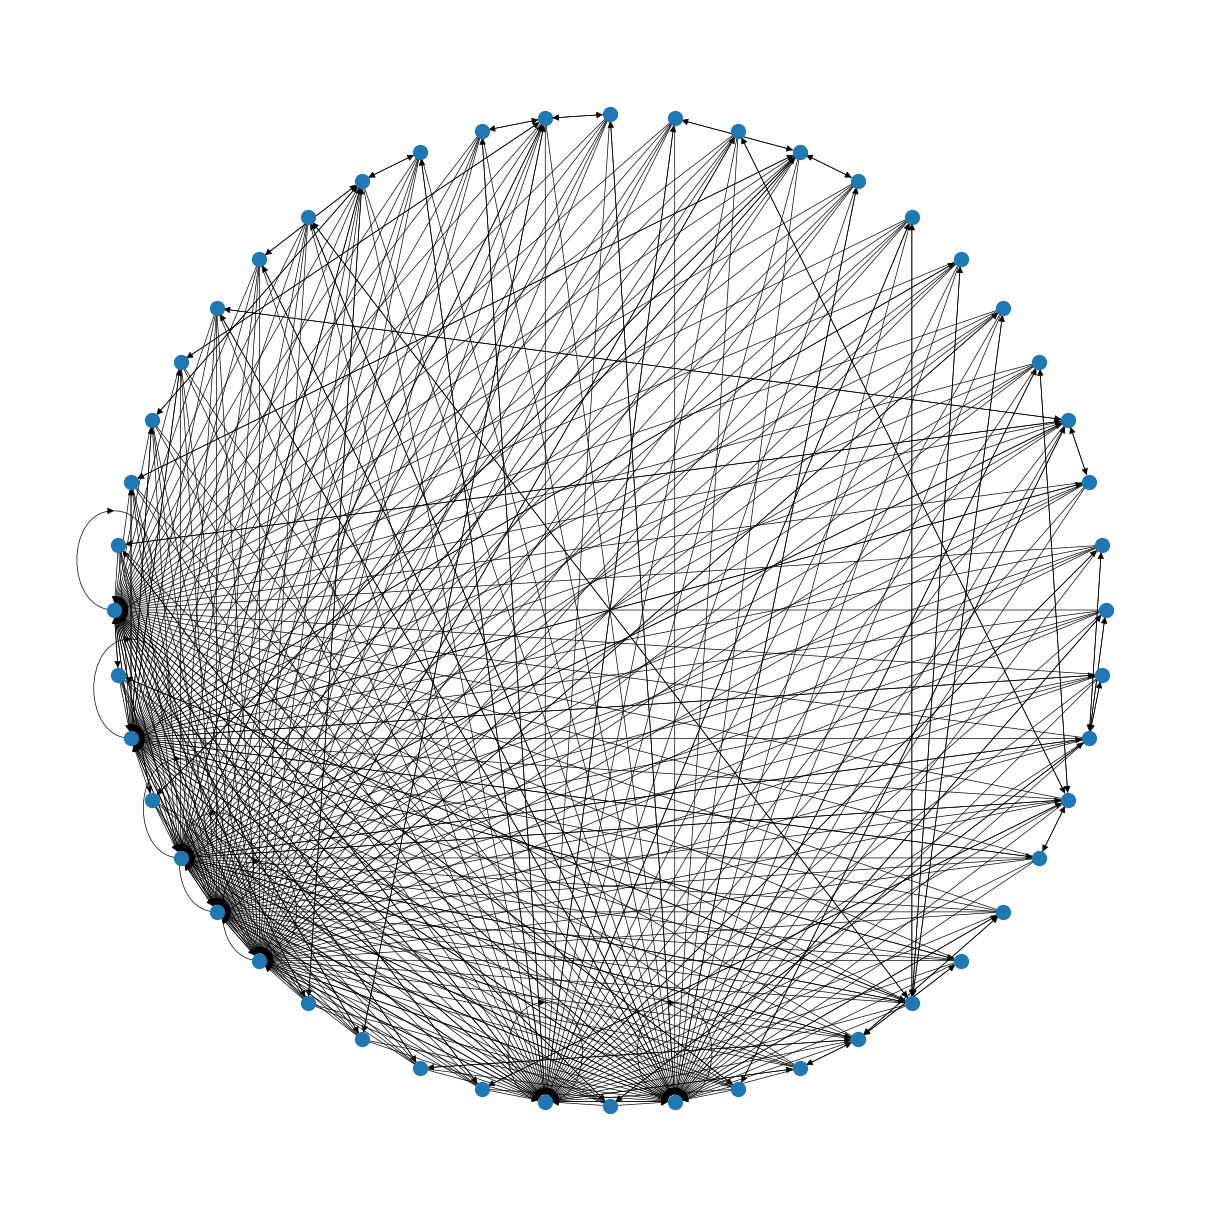

In [35]:
 
'''
Create an adjacency list in the following format:

adjacencyList = {
    'node A': ['nodeB', 'nodeC'],
    'node B': ['node C']
}
'''

G = nx.DiGraph()

for fromSite in adjacencyList:
    for toSite in adjacencyList[fromSite]:
        G.add_edge(fromSite, toSite)
        
nodes = list(G.nodes)
for node in nodes:
    if len(node) == 1:
        print(node)
        G.remove_node(node)
        
plt.figure(3,figsize=(12,12)) 
nx.draw(G, pos=nx.shell_layout(G), node_size=100, width=0.5)
plt.show()

### e.
From the website external links, choose one randomly and create a internet crawler.

In [206]:
# Code below

def proxima_url(url):
    urls = getExternalUrls(url)

    next_url = None

    if urls == None:
        return None

    if urls:
        next_url = random.choice(list(urls))
    
    if not next_url:
        internal = getInternalUrls(url)
        if internal:
            for site in internal:
                next_url = proxima_url(url + site)
                if next_url: return next_url
        return None

    return next_url

def percorrer(url):
    print(url)
    if not url:
        return

    proximo = proxima_url(url)

    percorrer(proximo)



In [217]:
percorrer("https://scraping-cap3.netlify.app/")

https://scraping-cap3.netlify.app/
https://github.com/kibonusp
https://services.github.com
https://twitter.com/github
https://support.twitter.com/articles/20170514
https://twitter.com/tos
https://privacy.twitter.com/
https://help.twitter.com/en/safety-and-security#ads-and-data-privacy
https://preferencecenter.twitter.com/
https://twitter.com/settings/email_notifications
https://help.twitter.com/using-twitter/twitter-supported-browsers
https://torproject.org
https://newsletter.torproject.org/
https://www.torproject.org/contact/
https://support.torproject.org
https://community.torproject.org/relay/community-resources/good-bad-isps/
https://www.psychz.net/
https://mailchi.mp/psychz.net/fi4gc078y6
None
